# Deep Reinforcement Learning for Robotic Systems 

## Synopsis

This notebook outlines the modelling and integration of the **[Proximal Policy Optimisation](http://arxiv.org/abs/1707.06347)** algorithm on an **inverted double pendulum** as a baseline study into advanced astrodynamical control systems, such as docking and berthing of spacecraft, and rocket trajectory stabilisation. 

--------

Produced by *[Mughees Asif](https://github.com/mughees-asif)*, under the supervision of [Dr. Angadh Nanjangud](https://www.sems.qmul.ac.uk/staff/a.nanjangud) (Lecturer in Aerospace/Spacecraft Engineering @ [Queen Mary, University of London](https://www.sems.qmul.ac.uk/)).



## 1. Overview

Proximal Policy Optimisation is a deep reinforcement learning algorithm developed by [OpenAI](https://spinningup.openai.com/en/latest/algorithms/ppo.html). It has proven to be successful in a variety of tasks ranging from enabling robotic systems in complex environments, to developing proficiency in computer gaming by using stochastic mathematical modelling to simulate real-life decision making. For the purposes of this research, the algorithm will be implemented to vertically stablise an inverted double pendulum, which is widely used in industry as a benchmark to validate the veracity of next-generation intelligent algorithms.

## 2. Model description

An inverted double pendulum is a characteristic example of a simple-to-build, non-linear, and chaotic mechanical system that has been widely studied in the fields of Robotics, Aerospace, Biomedical, Mechanical Engineering, and Mathematical Analysis.

<img src="images/dip_fbd.png" width="350" />

## 3. Variables

<img src="images/variables.png" width="400" />

## 4. Governing equations of motion

The following section utilises the [SymPy](https://www.sympy.org/en/index.html) package to derive the governing equations of motion. 

### 4.1. Basic modelling

<img src="images/dip_fbd_radius.png" width="300" />

In [325]:
# necessary imports

# mathematical
import sympy

# computational
import numpy as np
import torch as T # PyTorch
import torch.nn as nn # sequential model
import torch.optim as optim
from torch.distributions.categorical import Categorical # categorical distribution
import matplotlib.pyplot as plt
import hashlib
import random as _random
import struct
import sys
import math
import gym
import os
import seeding

In [326]:
# initiliase variables
t = sympy.symbols('t')        # time
m = sympy.symbols('m')        # mass of the cart
l = sympy.symbols('l')        # length of the pendulums, l_1 = l_2 = l
M = sympy.symbols('M')        # mass of the pendulums, M_1 = M_2 = M
I = sympy.symbols('I')        # moment of inertia
g = sympy.symbols('g')        # gravitational constant, 9.81 m/s^2
F = sympy.symbols('F')        # force applied to the cart

x = sympy.Function('x')(t)    # |
Θ = sympy.Function('Θ')(t)    # | --- functions of (t)
Φ = sympy.Function('Φ')(t)    # |

# cart
x_dot = x.diff(t)             # velocity

# pendulum(s) 
x_1 = x + (l*sympy.sin(Θ))    # | --- position
x_2 = l*sympy.cos(Θ)          # | 

v_1 = x_1 + l*sympy.sin(Φ)                                             # |
v_2 = x_2 + l*sympy.cos(Φ)                                             # | --- linear velocity
v_3 = sympy.sqrt(sympy.simplify(x_1.diff(t)**2 + x_2.diff(t)**2))      # |  
v_4 = sympy.sqrt(sympy.simplify(v_1.diff(t)**2 + v_2.diff(t)**2))      # |

Θ_dot = Θ.diff(t)             # | --- angular velocity
Φ_dot = Φ.diff(t)             # |

### 4.2. Kinetic and Potential Energy

In [327]:
# kinetic energy 
K = 0.5*((m*x_dot**2) + M*(v_3**2 + v_4**2) + I*(Θ_dot**2 + Φ_dot**2))

# potential energy 
P = M*g*l*(2*sympy.cos(Θ) + sympy.cos(Φ))

In [328]:
print('------------------------------\nThe kinetic energy, K, of the system:\n------------------------------')
K

------------------------------
The kinetic energy, K, of the system:
------------------------------


0.5*I*(Derivative(Θ(t), t)**2 + Derivative(Φ(t), t)**2) + 0.5*M*(2*l**2*cos(Θ(t) - Φ(t))*Derivative(Θ(t), t)*Derivative(Φ(t), t) + 2*l**2*Derivative(Θ(t), t)**2 + l**2*Derivative(Φ(t), t)**2 + 4*l*cos(Θ(t))*Derivative(x(t), t)*Derivative(Θ(t), t) + 2*l*cos(Φ(t))*Derivative(x(t), t)*Derivative(Φ(t), t) + 2*Derivative(x(t), t)**2) + 0.5*m*Derivative(x(t), t)**2

In [329]:
print('------------------------------\nThe potential energy, P, of the system:\n------------------------------')
P

------------------------------
The potential energy, P, of the system:
------------------------------


M*g*l*(2*cos(Θ(t)) + cos(Φ(t)))

### 4.3. The Lagrangian

The action $S$ of the cart (movement; left, right) is mathematically defined as:

$$S = \int_{t_{0}}^{t_{1}} K - P \,dt$$

but, $L = K - P$

$$\therefore S = \int_{t_{0}}^{t_{1}} L \,dt$$

In [330]:
# the lagrangian
L = K - P

print('------------------------------\nThe Lagrangian of the system is:\n------------------------------')
L

------------------------------
The Lagrangian of the system is:
------------------------------


0.5*I*(Derivative(Θ(t), t)**2 + Derivative(Φ(t), t)**2) - M*g*l*(2*cos(Θ(t)) + cos(Φ(t))) + 0.5*M*(2*l**2*cos(Θ(t) - Φ(t))*Derivative(Θ(t), t)*Derivative(Φ(t), t) + 2*l**2*Derivative(Θ(t), t)**2 + l**2*Derivative(Φ(t), t)**2 + 4*l*cos(Θ(t))*Derivative(x(t), t)*Derivative(Θ(t), t) + 2*l*cos(Φ(t))*Derivative(x(t), t)*Derivative(Φ(t), t) + 2*Derivative(x(t), t)**2) + 0.5*m*Derivative(x(t), t)**2

### 4.4. The Euler-Lagrange equations

The standard [Euler-Lagrange equation](https://www.ucl.ac.uk/~ucahmto/latex_html/chapter2_latex2html/node5.html) is:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = 0$$

To introduce the generalised force acting on the cart, the [Lagrange-D'Alembert Principle](https://en.wikipedia.org/wiki/D%27Alembert%27s_principle) is used:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = Q^{P}$$

Therefore, for a three-dimensional _working_ system, the equations of motion can be derived as:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = F - \dot x$$
$$\frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}} - \frac{\partial L}{\partial \theta} = 0$$
$$\frac{d}{dt}\frac{\partial L}{\partial \dot{\phi}} - \frac{\partial L}{\partial \phi} = 0$$

In [331]:
# euler-lagrange formulation
euler_1 = sympy.Eq((L.diff(x_dot).diff(t) - L.diff(x)).simplify().expand().collect(x.diff(t, t)), F - x.diff(t))
euler_2 = sympy.Eq((L.diff(Θ_dot).diff(t) - L.diff(Θ)).simplify().expand().collect(Θ.diff(t, t)), 0)
euler_3 = sympy.Eq((L.diff(Φ_dot).diff(t) - L.diff(Φ)).simplify().expand().collect(Φ.diff(t, t)), 0)

print('------------------------------\nThe Euler-Lagrange equations:\n------------------------------\n1.')
euler_1

------------------------------
The Euler-Lagrange equations:
------------------------------
1.


Eq(-2*M*l*sin(Θ(t))*Derivative(Θ(t), t)**2 - M*l*sin(Φ(t))*Derivative(Φ(t), t)**2 + 2*M*l*cos(Θ(t))*Derivative(Θ(t), (t, 2)) + M*l*cos(Φ(t))*Derivative(Φ(t), (t, 2)) + (2*M + 1.0*m)*Derivative(x(t), (t, 2)), F - Derivative(x(t), t))

In [332]:
print('2.')
euler_2

2.


Eq(-2.0*M*g*l*sin(Θ(t)) + 1.0*M*l**2*sin(Θ(t) - Φ(t))*Derivative(Φ(t), t)**2 + 1.0*M*l**2*cos(Θ(t) - Φ(t))*Derivative(Φ(t), (t, 2)) + 2.0*M*l*cos(Θ(t))*Derivative(x(t), (t, 2)) + (1.0*I + 2.0*M*l**2)*Derivative(Θ(t), (t, 2)), 0)

In [333]:
print('3.')
euler_3

3.


Eq(-1.0*M*g*l*sin(Φ(t)) - 1.0*M*l**2*sin(Θ(t) - Φ(t))*Derivative(Θ(t), t)**2 + 1.0*M*l**2*cos(Θ(t) - Φ(t))*Derivative(Θ(t), (t, 2)) + 1.0*M*l*cos(Φ(t))*Derivative(x(t), (t, 2)) + (1.0*I + 1.0*M*l**2)*Derivative(Φ(t), (t, 2)), 0)

### 4.5. Linearisation and acceleration

[Hartman-Grobman theorem](https://en.wikipedia.org/wiki/Hartman%E2%80%93Grobman_theorem)

The pendulum will achieve equilibrium when vertical, i.e. $\theta=0$ & $\phi=0$:

$$\sin(\theta)=\theta, \quad \cos(\theta)=1, \quad \dot\theta^{2}=0$$

$$\sin(\phi)=\phi, \quad \cos(\phi)=1, \quad \dot\phi^{2}=0$$

$$\sin(\theta - \phi)=\theta - \phi, \quad\quad \cos(\theta - \phi)=1$$

In [334]:
# linearise the system
matrix = [(sympy.sin(Θ), Θ), (sympy.cos(Θ), 1), (Θ_dot**2, 0), 
         (sympy.sin(Φ), Φ), (sympy.cos(Φ), 1), (Φ_dot**2, 0),
         (sympy.sin(Θ - Φ), Θ - Φ), (sympy.cos(Θ - Φ), 1)]

linear_1 = euler_1.subs(matrix)
linear_2 = euler_2.subs(matrix)
linear_3 = euler_3.subs(matrix)

print('------------------------------\nThe linear equations are: \n------------------------------\n1.')
linear_1

------------------------------
The linear equations are: 
------------------------------
1.


Eq(2*M*l*Derivative(Θ(t), (t, 2)) + M*l*Derivative(Φ(t), (t, 2)) + (2*M + 1.0*m)*Derivative(x(t), (t, 2)), F - Derivative(x(t), t))

In [335]:
print('2. ')
linear_2

2. 


Eq(-2.0*M*g*l*Θ(t) + 1.0*M*l**2*Derivative(Φ(t), (t, 2)) + 2.0*M*l*Derivative(x(t), (t, 2)) + (1.0*I + 2.0*M*l**2)*Derivative(Θ(t), (t, 2)), 0)

In [336]:
print('3. ')
linear_3

3. 


Eq(-1.0*M*g*l*Φ(t) + 1.0*M*l**2*Derivative(Θ(t), (t, 2)) + 1.0*M*l*Derivative(x(t), (t, 2)) + (1.0*I + 1.0*M*l**2)*Derivative(Φ(t), (t, 2)), 0)

In [337]:
# simplify for linear and angular acceleration
final_equations = sympy.linsolve([linear_1, linear_2, linear_3], [x.diff(t, t), Θ.diff(t, t), Φ.diff(t, t)])

x_ddot = final_equations.args[0][0].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, F)).simplify()
Θ_ddot = final_equations.args[0][1].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, F)).simplify()
Φ_ddot = final_equations.args[0][2].expand().collect((Θ, Θ_dot, x, x_dot, Φ, Φ_dot, F)).simplify()

print('------------------------------\nx_acceleration:\n------------------------------')
x_ddot      

------------------------------
x_acceleration:
------------------------------


(F*(4.0*I**2 + 12.0*I*M*l**2 + 4.0*M**2*l**4) - 4.0*I*M**2*g*l**2*Φ(t) - M**2*g*l**2*(16.0*I + 8.0*M*l**2)*Θ(t) - (4.0*I**2 + 12.0*I*M*l**2 + 4.0*M**2*l**4)*Derivative(x(t), t))/(8.0*I**2*M + 4.0*I**2*m + 4.0*I*M**2*l**2 + 12.0*I*M*l**2*m + 4.0*M**2*l**4*m)

In [338]:
print('------------------------------\nΘ_acceleration:\n------------------------------')
Θ_ddot

------------------------------
Θ_acceleration:
------------------------------


M*l*(-F*(8.0*I + 4.0*M*l**2) - 4.0*M*g*l**2*m*Φ(t) + g*(16.0*I*M + 8.0*I*m + 8.0*M**2*l**2 + 8.0*M*l**2*m)*Θ(t) + (8.0*I + 4.0*M*l**2)*Derivative(x(t), t))/(8.0*I**2*M + 4.0*I**2*m + 4.0*I*M**2*l**2 + 12.0*I*M*l**2*m + 4.0*M**2*l**4*m)

In [339]:
print('------------------------------\nΦ_acceleration:\n------------------------------')
Φ_ddot         

------------------------------
Φ_acceleration:
------------------------------


M*l*(-1.0*F*I + 1.0*I*Derivative(x(t), t) - 2.0*M*g*l**2*m*Θ(t) + g*(2.0*I*M + 1.0*I*m + 2.0*M*l**2*m)*Φ(t))/(2.0*I**2*M + 1.0*I**2*m + 1.0*I*M**2*l**2 + 3.0*I*M*l**2*m + 1.0*M**2*l**4*m)

## 5. Proximal Policy Optimisation

### 5.1. Overview[<sup>1</sup>](#fn1)
 
 * State-of-the-art Policy Gradient method.
 * An on-policy algorithm.
 * Can be used for environments with either discrete or continuous action spaces.
 * **PPO-Clip** doesn’t have a KL-divergence term in the objective and doesn’t have a constraint at all. Instead relies on specialized clipping in the objective function to remove incentives for the new policy to get far from the old policy.
 
<sup>1</sup><span id="fn1"></span>Referenced from [OpenAI](https://spinningup.openai.com/en/latest/algorithms/ppo.html) 

### 5.2. PPO-Clip mathematical model

$$ \begin{equation}\mathbf{
 L^{PPO} (\theta)=\mathbb{\hat{E}}_t\:[L^{CLIP}(\theta)-c_1L^{VF}(\theta)+c_2S[\pi_\theta](s_t)]}
 \end{equation}$$ 
 
1. $ L^{CLIP} (\theta)=\mathbb{\hat{E}}_t[\min(r_t(\theta)\:\hat{A}^t,\:\:clip(r_t(\theta),\:\:1-\epsilon,\:\:1+\epsilon)\hat{A}^t)]$ 
<br>*where*,
* $r_t(\theta)\:\hat{A}^t$: Surrogate objective is the probability ratio between a new policy network and an older policy network.

* $\epsilon$: Hyper-parameter; usually with a value of 0.2.

* clip$(r_t(\theta),\:\:1-\epsilon,\:\:1+\epsilon)\:\hat{A}^t$: Clipped version of the surrogate objective, where the probability ratio is truncated.

2. $c_1L^{VF}(\theta)$: Determines desirability of the current state.

3. $c_2S[\pi_\theta](s_t)$: The entropy term using Gaussian Distribution.

### 5.3. Neural Network [A2C]

In [340]:
class PPOStorage:
    # constructor - init values to empty lists
    def __init__(self, batch_size):
        self.states_encountered = []
        self.probability = []
        self.values = []
        self.actions = []
        self.rewards = []
        self.terminal_flag = []

        self.batch_size = batch_size

    # generate batches - defines the number of samples that will be propagated through the network
    def generate_batches(self):
        num_states = len(self.states_encountered)
        batch_start = np.arange(0, num_states, self.batch_size)
        idx = np.arange(num_states, dtype=np.int64)
        np.random.shuffle(idx) # shuffle to handle stochastic gradient descent
        batches = [idx[i:i+self.batch_size] for i in batch_start]
        
        # NOTE: maintain return order
        return np.array(self.states_encountered),\
                np.array(self.actions),\
                np.array(self.probability),\
                np.array(self.values),\
                np.array(self.rewards),\
                np.array(self.terminal_flag),\
                batches
    
    # store results from previous state
    def memory_storage(self, states_encountered, action, probability, values, reward, terminal_flag):
        self.states_encountered.append(states_encountered)
        self.actions.append(action)
        self.probability.append(probability)
        self.values.append(values)
        self.rewards.append(reward)
        self.terminal_flag.append(terminal_flag)

    # clear memory after retrieving state
    def memory_clear(self):
        self.states_encountered = []
        self.probability = []
        self.actions = []
        self.rewards = []
        self.terminal_flag = []
        self.values = []

# defines the actor        
class ActorNetwork(nn.Module):
    # constructor
    def __init__(self, num_actions, input_dimensions, learning_rate_alpha,
            fully_connected_layer_1_dimensions=256, fully_connected_layer_2_dimensions=256, 
                 chkpt_dir='tmp/ppo'):
        # call super-constructor 
        super(ActorNetwork, self).__init__()
        # save checkpoint
        # self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        
        # deep neural network (DNN)
        self.actor = nn.Sequential(
                # linear layers unpack input_dimensions
                nn.Linear(*input_dimensions, fully_connected_layer_1_dimensions),
                # ReLU: applies the rectified linear unit function element-wise
                nn.ReLU(),
                nn.Linear(fully_connected_layer_1_dimensions, fully_connected_layer_2_dimensions),
                nn.ReLU(),
                nn.Linear(fully_connected_layer_2_dimensions, num_actions),
            
                # softmax activation function: a mathematical function that converts a vector of numbers 
                # into a vector of probabilities, where the probabilities of each value are proportional to the 
                # relative scale of each value in the vector.
                nn.Softmax(dim=-1)
        )
        
        # optimizer: an optimization algorithm that can be used instead of the classical stochastic 
        # gradient descent procedure to update network weights iterative based in training data
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate_alpha)
        
        # handle type of device
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    # pass state forward through the DNN: calculate series of probabilities to draw from a distribution
    # to get actual action. Use action to get log probabilities for the calculation of the two probablities
    # for the learning function
    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        return dist

# defines the critic [NOTE: See comments above for individual function explanation]          
class CriticNetwork(nn.Module):
    def __init__(self, input_dimensions, learning_rate_alpha, fully_connected_layer_1_dimensions=256, 
                 fully_connected_layer_2_dimensions=256, chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        # self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dimensions, fully_connected_layer_1_dimensions),
                nn.ReLU(),
                nn.Linear(fully_connected_layer_1_dimensions, fully_connected_layer_2_dimensions),
                nn.ReLU(),
                nn.Linear(fully_connected_layer_2_dimensions, 1)
        )
        
        # same learning rate for both actor & critic -> actor is much more sensitive to the changes in the underlying
        # parameters
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate_alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)
        return value

# defines the agent 
class Agent:
    def __init__(self, num_actions, input_dimensions, gamma=0.99, learning_rate_alpha=3e-4, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, num_epochs=10):
        # save parameters
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.num_epochs = num_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(num_actions, input_dimensions, learning_rate_alpha)
        self.critic = CriticNetwork(input_dimensions, learning_rate_alpha)
        self.memory = PPOStorage(batch_size)
    
    # store memory; interface function
    def interface_agent_memory(self, state, action, probability, values, reward, terminal_flag):
        self.memory.memory_storage(state, action, probability, values, reward, terminal_flag)
    
    # choosing an action
    def action_choice(self, observation):
        # convert numpy array to a tensor
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        
        # distribution for choosing an action
        dist = self.actor(state)
        # value of the state
        value = self.critic(state)
        # sample distribution to get action
        action = dist.sample()

        # squeeze to eliminate batch dimensions
        probability = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probability, value

    # learning from actions
    def learn(self):
        # iterate over the number of epochs
        for _ in range(self.num_epochs):
            state_array, action_array, old_probability_array, values_array,\
            reward_array, terminal_flag_array, batches = \
                    self.memory.generate_batches()

            values = values_array
            # advantage
            advantage = np.zeros(len(reward_array), dtype=np.float32)
            
            # calculate advantage
            for time_step in range(len(reward_array)-1):
                discount = 1
                advantage_time_step = 0
                # from Schulman paper -> advantage function
                for k in range(time_step, len(reward_array)-1):
                    advantage_time_step += discount*(reward_array[k] + self.gamma*values[k+1]*\
                            (1-int(terminal_flag_array[k])) - values[k])
                    # multiplicative factor
                    discount *= self.gamma*self.gae_lambda
                advantage[time_step] = advantage_time_step
            # turn advantage into tensor
            advantage = T.tensor(advantage).to(self.actor.device)

            # convert values to a tensor
            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_array[batch], dtype=T.float).to(self.actor.device)
                old_probability = T.tensor(old_probability_array[batch]).to(self.actor.device)
                actions = T.tensor(action_array[batch]).to(self.actor.device)
                
                # pi(theta)_new: take states and pass to Actor to get the new distribution for new probability
                dist = self.actor(states)
                
                critic_value = self.critic(states)
                # new values of the state according to the Critic network
                critic_value = T.squeeze(critic_value)
                
                # calculate new probability
                new_probability = dist.log_prob(actions)
                # probability ratio; probabilities taken as exponential to get ratio
                probability_ratio = new_probability.exp() / old_probability.exp()
                # prob_ratio = (new_probs - old_probs).exp()
                
                weighted_probability = advantage[batch] * probability_ratio
                
                weighted_clipped_probability = T.clamp(probability_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                
                # negative due to gradient ascent
                actor_loss = -T.min(weighted_probability, weighted_clipped_probability).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()
                
                total_loss = actor_loss + 0.5*critic_loss
                
                # zero the gradients
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                
                # backpropagate total loss
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
        
        # at end of epochs clear memory
        self.memory.memory_clear()               

### 5.5. Environment

In [341]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

class CartPoleEnv(gym.Env):
    
    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = 'euler'

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array([self.x_threshold * 2,
                         np.finfo(np.float32).max,
                         self.theta_threshold_radians * 2,
                         np.finfo(np.float32).max],
                        dtype=np.float32)

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = np_random(seed)
        return [seed]

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

### 5.6. Test 

| episode:  0  | score: 59.00 |
| episode:  1  | score: 127.00 |
| episode:  2  | score: 18.00 |
| episode:  3  | score: 17.00 |
| episode:  4  | score: 21.00 |
| episode:  5  | score: 23.00 |
| episode:  6  | score: 19.00 |
| episode:  7  | score: 45.00 |
| episode:  8  | score: 63.00 |
| episode:  9  | score: 67.00 |
| episode:  10  | score: 27.00 |
| episode:  11  | score: 14.00 |
| episode:  12  | score: 11.00 |
| episode:  13  | score: 20.00 |
| episode:  14  | score: 10.00 |
| episode:  15  | score: 19.00 |
| episode:  16  | score: 16.00 |
| episode:  17  | score: 19.00 |
| episode:  18  | score: 15.00 |
| episode:  19  | score: 16.00 |
| episode:  20  | score: 23.00 |
| episode:  21  | score: 11.00 |
| episode:  22  | score: 58.00 |
| episode:  23  | score: 36.00 |
| episode:  24  | score: 43.00 |
| episode:  25  | score: 26.00 |
| episode:  26  | score: 31.00 |
| episode:  27  | score: 111.00 |
| episode:  28  | score: 41.00 |
| episode:  29  | score: 29.00 |
| episode:  30  | 

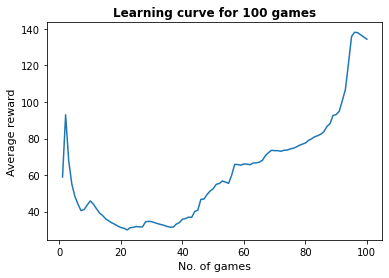

In [342]:
# create environment
env = CartPoleEnv()
N = 20
batch_size = 5
num_epochs = 4
learning_rate_alpha = 0.0003
agent = Agent(num_actions=env.action_space.n, batch_size=batch_size, 
                learning_rate_alpha=learning_rate_alpha, num_epochs=num_epochs, 
                input_dimensions=env.observation_space.shape)

# number of games
num_games = 100

# track best score: minimum score for the environment
best_score = env.reward_range[0]
score_history = []

learn_iters = 0
average_score = 0
num_steps = 0

for i in range(num_games):
    observation = env.reset()
    terminal_flag = False
    score = 0
    while not terminal_flag:
        # choose action based on the current state of the environment
        action, probability, value = agent.action_choice(observation)
        observation_, reward, terminal_flag, info = env.step(action)
        num_steps += 1
        score += reward
        
        # store transition in the agent memory
        agent.interface_agent_memory(observation, action, probability, value, reward, terminal_flag)
        if num_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    average_score = np.mean(score_history[-100:])

    if average_score > best_score:
        best_score = average_score

    print('| episode: ', i, ' | score: %.2f |' % score)
    
x = [i+1 for i in range(len(score_history))]

def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Learning curve for %s games' % (x[-1]), fontweight='bold')
    plt.xlabel('No. of games', fontsize=11)
    plt.ylabel('Average reward', fontsize=11)
    
plot_learning_curve(x, score_history)